## Setup

In [1]:
from joblib import Parallel, delayed
from tqdm import tqdm
import numba
from typing import Tuple, List
from matchms import Spectrum
from matchms.typing import SpectrumType
import numpy as np
import pandas as pd
from pathlib import Path
import json
from numba import cuda
from matchms import Spectrum
from numba.cuda.cudadrv.devicearray import DeviceNDArray
from numba import types
import math
import warnings
from numba.core.errors import NumbaPerformanceWarning
import time
from time import perf_counter
from itertools import product

# Ignore NumbaPerformanceWarning
warnings.simplefilter("ignore", category=NumbaPerformanceWarning)

np.set_printoptions(precision=3)

from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

def process_spectrum(spectrum):
    spectrum = select_by_mz(spectrum, mz_from=10.0, mz_to=1000.0)
    spectrum = normalize_intensities(spectrum)
    spectrum = select_by_relative_intensity(spectrum, intensity_from=0.001)
    spectrum = reduce_to_number_of_peaks(spectrum, n_max=1000)
    spectrum = require_minimum_number_of_peaks(spectrum, n_required=5)
    return spectrum


def get_ref_spectra_from_df(spectra_df, limit=None):
    # This function will take a dataframe with spectra and return a list of matchms spectra
    # Argh, This function is annoyingly slow. Added simple parallelization.
    
    # for index, row in spectra_df.iterrows():
    def fn(index, row):
        pbid = row["pbid"]
        precursor_mz = row["precursor_mz"]
        smiles = row["pb_smiles"]
        inchikey = row["pb_inchikey"]
        mz_array = np.array(json.loads(row["peaks_mz"]))
        intensity_array = np.array(json.loads(row["peaks_intensities"]))
        sp = Spectrum(mz=mz_array, intensities=intensity_array,
                        metadata={'id': pbid, 
                                'precursor_mz': precursor_mz, 
                                'smiles': smiles, 
                                'inchikey': inchikey}) 
        sp = process_spectrum(sp)
        return sp
    if limit is not None:
        spectra_df = spectra_df.head(limit)
    spectra = Parallel(-2)(delayed(fn)(index, row) for index, row in tqdm(spectra_df.iterrows(), total=len(spectra_df)) )
    spectra = [s for s in spectra if s is not None]
    return spectra

def spectra_peaks_to_tensor(spectra: list, dtype:str='float32'):
    sp_max_shape = max(len(s.peaks) for s in spectra)
    mz = np.empty((len(spectra), sp_max_shape), dtype=dtype)
    int = np.empty((len(spectra), sp_max_shape), dtype=dtype)
    batch = np.empty(len(spectra),dtype=np.int32)
    for i, s in enumerate(spectra):
        # .to_numpy creates an unneeded copy - we don't need it
        # arr = s.peaks
        mz[i, :len(s.peaks)] = s._peaks.mz#arr[...,0] 
        int[i, :len(s.peaks)] = s._peaks.intensities#arr[...,1]
        batch[i] = len(s.peaks)
    spec = np.stack([mz, int], axis=0)
    return spec, batch

def batches(lst, batch_size):
    for i in range(0, len(lst), batch_size):
        yield lst[i:i + batch_size]

In [2]:
assert cuda.detect()

CudaSupportError: Error at driver init: Call to cuInit results in CUDA_ERROR_UNKNOWN (999)

In [3]:
ref_spectra_df_path = Path("data/input/example_dataset_tornike.csv")
ref_spectra_df = pd.read_csv(ref_spectra_df_path)
large_references = get_ref_spectra_from_df(ref_spectra_df, limit=16384)

100%|██████████| 16384/16384 [00:05<00:00, 2801.14it/s]


In [4]:
## Define constants
tolerance: float = 0.1
shift: float = 0
mz_power: float = 0
int_power: float = 1

## How many pairs
R = 1024 * 4
Q = 1024 * 4
# We know absolute max spectrum size we can have...
MN = max(len(s.peaks) for s in large_references)

## GPU-specific constants
# Threads per block (max is 32,32)
# Blocks per grid (enough to cover all Rs and Qs)
THREADS_PER_BLOCK = (32, 32)
BLOCKS_PER_GRID_X = math.ceil(R / THREADS_PER_BLOCK[0])
BLOCKS_PER_GRID_Y = math.ceil(Q / THREADS_PER_BLOCK[1])
BLOCKS_PER_GRID = (BLOCKS_PER_GRID_X, BLOCKS_PER_GRID_Y)

# 'float32' runs MUCH faster, and has around ~0.05% error rate
# 'float64' is slower, but has ~0.00095% error rate
# Greedy cosine is unstable, so it's virtually impossible to have 0% error rate
dtype = 'float64'

# Smaller match limit increases speed dramatically!
# But any value less than M * N will cause a tiny portion of 
# pairs to "overflow" and have tiny error in calculation.
# It is much more efficient to calculate these overflows 
# separately rather than to increase MATCH_LIMIT.
MATCH_LIMIT = 128

In [5]:
@cuda.jit
def process(
            rspec: DeviceNDArray,
            qspec: DeviceNDArray,
            
            lens: DeviceNDArray,          
            
            out: DeviceNDArray,
            overflow: DeviceNDArray,
            ):
    i,j = cuda.grid(2)
    thread_i = cuda.threadIdx.x
    thread_j = cuda.threadIdx.y
    block_size_x = cuda.blockDim.x
    block_size_y = cuda.blockDim.y
    
    # mem = cuda.shared.array((8, ))
    # We aren't out of the RxQ grid
    if i < R and j < Q:
        # Init values (we expect these to be uninitialized)
        overflow[i,j] = 0
        out[i,j] = 0
        
        # mem = cuda.shared.array((4, 4, 4, 32), types.float32)
        rmz = rspec[0]
        rint = rspec[1]
        qmz = qspec[0]
        qint = qspec[1]
        # In this i,j, We get length of r and q spectrums 
        # since they are batched, there might be extra filler elements
        rlen = lens[0]
        qlen = lens[1]
        
        rleni = rlen[i]
        qlenj = qlen[j]
        
        spec1_mz = rmz[i]
        spec1_int = rint[i]
        
        spec2_mz = qmz[j]
        spec2_int = qint[j]
        
        lowest_idx = types.int32(0)
        num_match = types.int32(0)
        
        matches = cuda.local.array((2, MATCH_LIMIT), types.int16)
        for peak1_idx in range(rleni):
            mz = spec1_mz[peak1_idx]

            low_bound = mz - tolerance
            high_bound = mz + tolerance
            
            for peak2_idx in range(lowest_idx, qlenj):
                mz2 = spec2_mz[peak2_idx] + shift
                if mz2 > high_bound:
                    break
                if mz2 < low_bound:
                    lowest_idx = peak2_idx
                else:
                    if num_match < MATCH_LIMIT:
                        matches[0, num_match] = peak1_idx
                        matches[1, num_match] = peak2_idx
                        num_match += 1
                    else:
                        overflow[i, j, 0] = 1 # This is the errorcode for overflow
                        break

        if num_match == 0: 
            return
        
        # SLOW, calculate norm ( This should be done in several threads )
        # score_norm = types.float32(0.0)
        score_norm = types.float32(1.0)
        score_norm_spec1 = types.float32(0.0)
        score_norm_spec2 = types.float32(0.0)
        
        for peak1_idx in range(rleni):
            score_norm_spec1 += ((spec1_mz[peak1_idx] ** mz_power) * (spec1_int[peak1_idx] ** int_power)) ** 2
        for peak2_idx in range(qlenj):
            score_norm_spec2 += ((spec2_mz[peak2_idx] ** mz_power) * (spec2_int[peak2_idx] ** int_power)) ** 2
        score_norm = math.sqrt(score_norm_spec1 * score_norm_spec2)
        
        # Quite slow - Bubble sort (This should also be done in several threads)
        # We need two cases, bubble sort up to 50 elems is fine
        score = types.float32(0.0)
        used_matches = types.int32(0)
        for _ in range(0, num_match):
            max_prod = types.float64(-1.0)
            max_peak1_idx = -1
            max_peak2_idx = -1
            
            for sj in range(0, num_match):
                if matches[0, sj] >= 0:
                    peak1_idx = matches[0, sj]
                    peak2_idx = matches[1, sj]
                    
                    power_prod_spec1 = (spec1_mz[peak1_idx] ** mz_power) * (spec1_int[peak1_idx] ** int_power)
                    power_prod_spec2 = (spec2_mz[peak2_idx] ** mz_power) * (spec2_int[peak2_idx] ** int_power)
                    prod = power_prod_spec1 * power_prod_spec2
                    if prod > max_prod:
                        max_prod = prod
                        max_peak1_idx = peak1_idx
                        max_peak2_idx = peak2_idx

            if max_prod > 0:
                for sj in range(0, num_match):
                    if matches[0, sj] == max_peak1_idx or matches[1, sj] == max_peak2_idx:
                        matches[0, sj] = -1 # "Remove" it
                        matches[1, sj] = -1 # "Remove" it
                score += max_prod
                used_matches += 1
                
            if max_prod < 0:
                break
            
        score = score / score_norm
            
        out[i,j,0] = score
        out[i,j,1] = used_matches

## Regular CPU-bound run:

In [10]:
references = large_references[:R]
queries = large_references[:Q]

print(f"Total pairs to compare: {len(references)} * {len(queries)} = {len(queries) * len(references)}")

Total pairs to compare: 1024 * 1024 = 1048576


In [11]:
@numba.njit
def find_matches(spec1_mz: np.ndarray, spec2_mz: np.ndarray,
                 tolerance: float, shift: float = 0) -> List[Tuple[int, int]]:
    """Faster search for matching peaks.
    Makes use of the fact that spec1 and spec2 contain ordered peak m/z (from
    low to high m/z).

    Parameters
    ----------
    spec1_mz:
        Spectrum peak m/z values as numpy array. Peak mz values must be ordered.
    spec2_mz:
        Spectrum peak m/z values as numpy array. Peak mz values must be ordered.
    tolerance
        Peaks will be considered a match when <= tolerance appart.
    shift
        Shift peaks of second spectra by shift. The default is 0.

    Returns
    -------
    matches
        List containing entries of type (idx1, idx2).

    """
    
    lowest_idx = 0
    matches = []
    for peak1_idx in range(spec1_mz.shape[0]):
        mz = spec1_mz[peak1_idx]
        low_bound = mz - tolerance
        high_bound = mz + tolerance
        for peak2_idx in range(lowest_idx, spec2_mz.shape[0]):
            mz2 = spec2_mz[peak2_idx] + shift
            if mz2 > high_bound:
                break
            if mz2 < low_bound:
                lowest_idx = peak2_idx
            else:
                matches.append((peak1_idx, peak2_idx))
                # print((peak1_idx, peak2_idx))
    # print(matches)
    return matches


@numba.njit(fastmath=True)
def score_best_matches(matching_pairs: np.ndarray, spec1: np.ndarray,
                       spec2: np.ndarray, mz_power: float = 0.0,
                       intensity_power: float = 1.0) -> Tuple[float, int]:
    """Calculate cosine-like score by multiplying matches. Does require a sorted
    list of matching peaks (sorted by intensity product)."""
    score = float(0.0)
    used_matches = int(0)
    used1 = set()
    used2 = set()
    for i in range(matching_pairs.shape[0]):
        if not matching_pairs[i, 0] in used1 and not matching_pairs[i, 1] in used2:
            score += matching_pairs[i, 2]
            used1.add(matching_pairs[i, 0])  # Every peak can only be paired once
            used2.add(matching_pairs[i, 1])  # Every peak can only be paired once
            # print(i, matching_pairs[i,0], matching_pairs[i,1], used_matches, score)
            used_matches += 1

    # Normalize score:
    spec1_power = spec1[:, 0] ** mz_power * spec1[:, 1] ** intensity_power    
    spec2_power = spec2[:, 0] ** mz_power * spec2[:, 1] ** intensity_power

    # print(spec1_power)
    # print(spec2_power)
    # raise
    score_norm = (np.sum(spec1_power ** 2) ** 0.5 * np.sum(spec2_power ** 2) ** 0.5)
    # print(score, score_norm, used_matches)
    score = score/score_norm
    # print(score, "/", score_norm)
    # raise
    return score, used_matches

@numba.njit
def collect_peak_pairs(spec1: np.ndarray, spec2: np.ndarray,
                       tolerance: float, shift: float = 0, mz_power: float = 0.0,
                       intensity_power: float = 1.0):
    # pylint: disable=too-many-arguments
    """Find matching pairs between two spectra.

    Args
    ----
    spec1:
        Spectrum peaks and intensities as numpy array.
    spec2:
        Spectrum peaks and intensities as numpy array.
    tolerance
        Peaks will be considered a match when <= tolerance appart.
    shift
        Shift spectra peaks by shift. The default is 0.
    mz_power:
        The power to raise mz to in the cosine function. The default is 0, in which
        case the peak intensity products will not depend on the m/z ratios.
    intensity_power:
        The power to raise intensity to in the cosine function. The default is 1.

    Returns
    -------
    matching_pairs : numpy array
        Array of found matching peaks.
    """
    matches = find_matches(spec1[:, 0], spec2[:, 0], tolerance, shift)
    # global a
    # a = matches
    # matches_op = find_matches_opt(spec1[:, 0], spec2[:, 0], tolerance, shift)
    # global b
    # b = matches_op
    # assert np.allclose(matches, matches_op)
    
    idx1 = [x[0] for x in matches]
    idx2 = [x[1] for x in matches]
    if len(idx1) == 0:
        return None
    matching_pairs = []
    for i, idx in enumerate(idx1):
        power_prod_spec1 = (spec1[idx, 0] ** mz_power) * (spec1[idx, 1] ** intensity_power)
        power_prod_spec2 = (spec2[idx2[i], 0] ** mz_power) * (spec2[idx2[i], 1] ** intensity_power)
        # print((idx, idx2[i], power_prod_spec1 * power_prod_spec2))
        matching_pairs.append([idx, idx2[i], power_prod_spec1 * power_prod_spec2])
    return np.array(matching_pairs.copy())


start_collect_peaks = time.time()
pairs_to_score_list = []
scores = []

# We use this array to compare results from CPU to results from GPU
out_true = np.full((len(references), len(queries), 2), fill_value=0, dtype='float32')
spec1s = []
for i,spectrum_1 in enumerate(references):
    spec1s.append([i, spectrum_1.peaks.to_numpy])
spec2s = []
for j,spectrum_2 in enumerate(queries):
    spec2s.append([j, spectrum_2.peaks.to_numpy])
    
total=len(spec1s) * len(spec2s)
for (i, spec1), (j, spec2) in tqdm( product(spec1s, spec2s), total=total):
        matching_pairs = collect_peak_pairs(
                    spec1, 
                    spec2, 
                    tolerance=tolerance,
                    shift=shift, 
                    mz_power=mz_power,
                    intensity_power=int_power,
        )
        if matching_pairs is not None:
            matching_pairs = matching_pairs[np.argsort(matching_pairs[:, 2])[::-1], :] 
            score = score_best_matches(matching_pairs, spec1, spec2, 
                                       mz_power, int_power)
            scores.append(score)
            out_true[i,j,0] = score[0]
            out_true[i,j,1] = score[1]

duration = time.time() - start_collect_peaks
print("Time to collect matching pairs:", duration)
persec = total / duration
print(f"Speed at {persec:.1f} pairs/sec")
print(f"Estimated {(100_000 * 1_500_000 / persec) / 3600:.2f}hrs per 100k x 1.5mln")


100%|██████████| 1048576/1048576 [00:12<00:00, 83106.05it/s]

Time to collect matching pairs: 12.6753830909729
Speed at 82725.4 pairs/sec
Estimated 503.67hrs per 100k x 1.5mln


# GPU-based solution

In [12]:
rspec, references_cutoff = spectra_peaks_to_tensor(references, dtype=dtype)
qspec, queries_cutoff  = spectra_peaks_to_tensor(queries, dtype=dtype)

rspec_cu = cuda.to_device(rspec)
qspec_cu = cuda.to_device(qspec)

lens_cu = cuda.to_device(np.stack([references_cutoff, queries_cutoff]))

# Batching 
N = rspec_cu.shape[-1] 
M = qspec_cu.shape[-1]

print("Rspec:", rspec_cu.shape, rspec_cu.dtype, "Qspec", qspec_cu.shape, qspec_cu.dtype)

Rspec: (2, 1024, 211) float64 Qspec (2, 1024, 211) float64


In [13]:
from time import perf_counter
iters = 32

# Init empty (faster) and set values in GPU
out = np.empty((R, Q, 2), dtype='float32')
overflow = np.empty((R, Q, 1), dtype='uint8')

out_cu = cuda.to_device(out)
overflow_cu = cuda.to_device(overflow)

# Warm up
process[(1,1), THREADS_PER_BLOCK](rspec_cu, qspec_cu,
                lens_cu,
                out_cu, overflow_cu,)

perf = perf_counter()
# Iterate kernel `iter` times and average performance
for _ in tqdm(range(iters), desc="Run x32, to get avg perf."):
    process[BLOCKS_PER_GRID, THREADS_PER_BLOCK](
                    rspec_cu, qspec_cu,
                    lens_cu,
                    out_cu, overflow_cu,
                    )
    cuda.synchronize()
duration = perf_counter() - perf
persec = iters * (R * Q) / duration
out_cu.copy_to_host(out)
overflow_cu.copy_to_host(overflow)

print(f"Speed at {persec:.1f}/sec")
print(f"Estimated {(100_000 * 1_500_000 / persec) / 3600:.2f}hrs per 100k x 1.5mln")

non_overflow = (1-overflow)
out_underflow = out * non_overflow

out_true_underflow = out_true * non_overflow

print("Perfectly correct?:", np.allclose(out, out_true))
print("Except overflows, pefectly correct?:", np.allclose(out_underflow, out_true_underflow))
print(f"Total comparisons: ", R * Q * 2)
tc = np.isclose(out[...,:2], out_true[...,:2])
print(f"Total correct: {(tc).sum()} ({tc.sum() / (R * Q * 2 ) * 100 :.6f}%)")
tc_ov = ((1-tc)*(overflow)).sum()
tc_noov = ((1-tc)*(1-overflow)).sum()
print(f"Total wrong: {(1-tc).sum()} ({(1-tc).sum() / (R * Q * 2 ) * 100 :.6f}%)")
print(f"\t{tc_ov} ({tc_ov / (R * Q * 2 ) * 100 :.6f}%) from overflows; {tc_noov} ({tc_noov / (R * Q * 2 ) * 100 :.6f}%) otherwise")

print("Overflows ====")
print(f"Overflows at MATCH_LIMIT={MATCH_LIMIT} : {overflow.sum()}, {overflow.mean() * 100:.5f}%")

print("Matches =====")
print(f"% correct : {np.isclose(out_underflow[...,1], out_true_underflow[...,1]).mean() * 100:.5f}%")
print(f"% under : {(out_underflow[...,1] < out_true_underflow[...,1]).mean() * 100:.5f}%")
print(f"% over : {(out_underflow[...,1] > out_true_underflow[...,1]).mean() * 100:.5f}%")

print("Scores =====")
print(f"% correct : {np.isclose(out_underflow[...,0], out_true_underflow[...,0]).mean() * 100:.5f}%")

Run x32, to get avg perf.: 100%|██████████| 32/32 [00:01<00:00, 16.27it/s]


Speed at 17047389.5/sec
Estimated 2.44hrs per 100k x 1.5mln
Perfectly correct?: False
Except overflows, pefectly correct?: False
Total comparisons:  2097152
Total correct: 2094206 (99.859524%)
Total wrong: 2946 (0.140476%)
	2932 (0.139809%) from overflows; 14 (0.000668%) otherwise
Overflows ====
Overflows at MATCH_LIMIT=128 : 1488, 0.14191%
Matches =====
% correct : 99.99943%
% under : 0.00038%
% over : 0.00019%
Scores =====
% correct : 99.99924%


# Compare the two results

In [10]:
cpu = out_true
gpu = out

In [11]:
print(cpu.shape, gpu.shape)

(1024, 1024, 2) (1024, 1024, 2)


Example: Get normed similarity and num_matches for R no. 42 and Q no. 77.

In [12]:
print("Sim from CPU: ", cpu[42, 77, 0], " And from GPU", gpu[42, 77, 0])
print("Score of 0 means the we didn't find any matches. So, matches should be 0. Let's check!")

Sim from CPU:  0.0  And from GPU 0.0
Score of 0 means the we didn't find any matches. So, matches should be 0. Let's check!


Get num matches for R no. 42 and Q no. 77.

In [13]:
print("Sim from CPU: ", cpu[42, 77, 1], " And from GPU", gpu[42, 77, 1])

Sim from CPU:  0.0  And from GPU 0.0


Let's see some other scores that aren't zero. `cpu[32,32]` will show `[<similarity>, <num matches>]` when we print it:

In [14]:
print('CPU:',cpu[32, 32])
print('GPU:',gpu[32, 32])

CPU: [ 0.457 13.   ]
GPU: [ 0.457 13.   ]


Let's see what happens when GPU overflows! This doesn't ever happen in CPU.
We keep track of overflows in array called `overflow`. If `overflow[i,j] == 1`, an overflow happened while comparing R[i] and Q[i]. However, score should still be reasonably close in CPU/GPU.

In [15]:
print("Overflow shape", overflow.shape)
print("Small sample of overflow...")
print(overflow[:16,:32].squeeze())
print("If you see any 1's, you are pretty lucky! We have only 0.02% overflows")

Overflow shape (1024, 1024, 1)
Small sample of overflow...
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0

Let's any first overflow:

In [16]:
gpu_ov = gpu[(overflow == 1).squeeze()]
cpu_ov = cpu[(overflow == 1).squeeze()]

Let's see them side-by-side:

In [17]:
np.set_printoptions(precision=5)
print("Overflows only!")
print("GPU score, GPU count, CPU score, CPU count")
print(np.c_[gpu_ov[:16], cpu_ov[:16]])

Overflows only!
GPU score, GPU count, CPU score, CPU count
[[9.02827e-02 5.50000e+01 1.02779e-01 6.00000e+01]
 [5.03936e-01 6.40000e+01 5.03944e-01 6.40000e+01]
 [8.95316e-02 5.90000e+01 8.95345e-02 6.00000e+01]
 [9.81815e-02 5.20000e+01 1.03995e-01 5.90000e+01]
 [5.62814e-01 6.20000e+01 5.62818e-01 6.30000e+01]
 [1.04077e-01 5.40000e+01 1.06113e-01 5.70000e+01]
 [1.66156e-01 6.60000e+01 1.66509e-01 6.70000e+01]
 [3.60311e-01 5.90000e+01 3.66729e-01 7.00000e+01]
 [4.42532e-01 6.00000e+01 4.43200e-01 6.50000e+01]
 [4.86722e-02 6.80000e+01 4.87097e-02 7.10000e+01]
 [4.12475e-02 6.80000e+01 4.12758e-02 7.00000e+01]
 [3.38245e-02 6.50000e+01 3.40067e-02 6.70000e+01]
 [1.60929e-01 6.40000e+01 1.65542e-01 7.40000e+01]
 [3.33284e-01 5.90000e+01 3.78094e-01 7.80000e+01]
 [4.49645e-01 5.80000e+01 4.85082e-01 7.60000e+01]
 [4.52101e-01 5.80000e+01 4.72201e-01 7.30000e+01]]


# Full run (batched GPU solution)

In [10]:
# How many batches do we have?

# Full run
references = large_references
queries = large_references

TOTAL_BATCHES = math.ceil( len(references) / R ) * math.ceil( len(queries) / Q)
print("Total batches: ", TOTAL_BATCHES)
print(f"Total pairs considered: {len(references)} * {len(queries)} = {len(references) * len(queries)}")

stream_outputs = [np.empty((R, Q, 2), dtype='float32') for _ in range(TOTAL_BATCHES)]
stream_overflows = [np.empty((R, Q, 1), dtype='uint8') for _ in range(TOTAL_BATCHES)]
streams = [cuda.stream() for _ in range(TOTAL_BATCHES)]

# Preload each batch so that we don't have to load any R,Q twice
# TODO: Guess these can be parallelised more, but it's not worth it to spend time on
# For now...
batches_r = []
for rbatch in tqdm(batches(references, R)):
    rspec, rlen = spectra_peaks_to_tensor(rbatch, dtype=dtype)
    batches_r.append([rspec, rlen])
    
batches_q = list()
for qbatch in tqdm(batches(queries, Q)):
    qspec, qlen  = spectra_peaks_to_tensor(qbatch, dtype=dtype)
    batches_q.append([qspec, qlen])
    
batches_rq = list(product(batches_r, batches_q))

# Start processing each loaded batch in parallel (using streams)
start = perf_counter()
for batch_i in tqdm(range(TOTAL_BATCHES)):
    stream = streams[batch_i]
    out = stream_outputs[batch_i]
    overflow = stream_overflows[batch_i]
    
    out_cu = cuda.device_array((R, Q, 2), dtype='float32', stream=stream)
    overflow_cu = cuda.device_array((R, Q, 1), dtype='uint8', stream=stream)
    
    (rspec, rlen), (qspec, qlen) = batches_rq[batch_i]
    lens = np.zeros((2, max(R, Q)), 'int32')
    lens[0,:len(rlen)] = rlen
    lens[1,:len(qlen)] = qlen
    with cuda.pinned(rspec, qspec, lens, out, overflow,):
        rspec_cu = cuda.to_device(rspec, stream=stream)
        qspec_cu = cuda.to_device(qspec, stream=stream)
        lens_cu = cuda.to_device(lens, stream=stream)
        process[BLOCKS_PER_GRID, THREADS_PER_BLOCK, stream](
                rspec_cu, qspec_cu,
                lens_cu,
                out_cu, overflow_cu,
        )
        out_cu.copy_to_host(out, stream=stream)
        overflow_cu.copy_to_host(overflow, stream=stream)
        
cuda.synchronize()
duration = perf_counter() - start
persec = len(references) * len(queries) / duration
print(f"Speed at {persec:.1f} pairs/sec")
print(f"Estimated {(100_000 * 1_500_000 / persec) / 3600:.2f}hrs per 100k x 1.5mln")

Total batches:  16
Total pairs considered: 16084 * 16084 = 258695056


4it [00:00,  8.08it/s]
4it [00:00,  8.10it/s]
100%|██████████| 16/16 [00:18<00:00,  1.16s/it]

Speed at 13980690.9 pairs/sec
Estimated 2.98hrs per 100k x 1.5mln


# Small sanity-checking

Right now, matching "batches" must have 1.0 (or very close, if overflow happened) in the diagonal, since we selected our references and queries to be exactly the same. 0th batch should be matching, so diagonal must be close to 1.0. Let's see. 

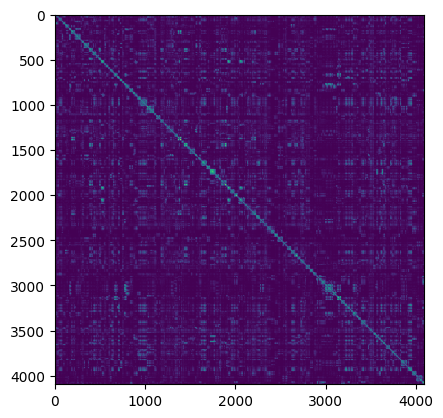

In [20]:
import matplotlib.pyplot as plt

plt.matshow(stream_outputs[0][...,0])

Second batch is "mismatched", so no diagonal here.

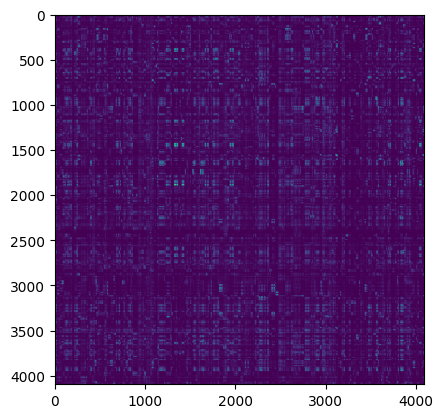

In [21]:
import matplotlib.pyplot as plt

plt.matshow(stream_outputs[1][...,0])

We can get the next "matched" by the following reasoning:

- We have 16 batches in total. 
- If you aligned these batches in 4x4 grid, in row-major order (fill first row, fill next row, etc)
- Then the second matched batch will be 5.


- **0**, 1, 2, 3,
- 4, **5**, 6, 7,
- ...
- ...

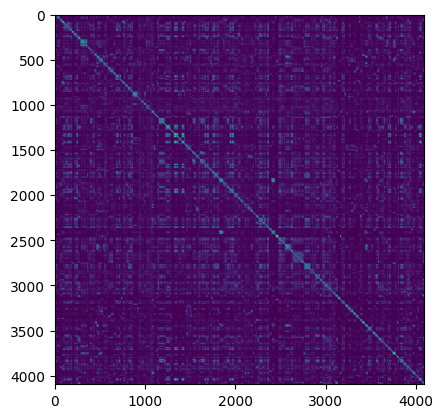

In [27]:
import matplotlib.pyplot as plt

plt.matshow(stream_outputs[5][...,0])

We know the last batch can be cut-off - because we need to batch refs and ques into R- Q- sized batches, most of the times length of all refs/queries won't 
be perfectly divisible by Q. In this case, we will have a continous black zero region in the outputs - either many zero columns, or many zero rows, in the right or bottom of the matrix.

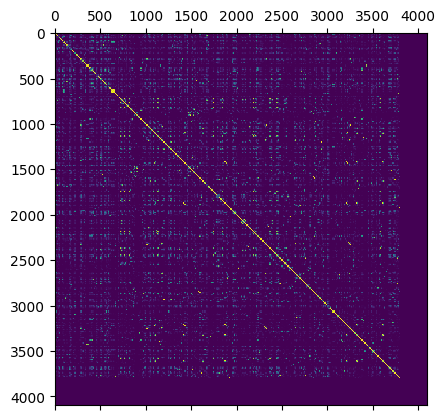

In [28]:
plt.matshow(stream_outputs[-1][...,0])

In [132]:
# for batch_i, (rbatch, qbatch) in enumerate(product(batches_r, batches_q)):
#     out_true = np.empty((len(rbatch), len(qbatch), 2), dtype='float32')
#     for (i, spec1), (j, spec2) in tqdm( product( enumerate(rbatch), enumerate(qbatch)), total=R * Q):
#         spec1 = spec1.peaks.to_numpy
#         spec2 = spec2.peaks.to_numpy
#         matching_pairs = collect_peak_pairs(
#             spec1,
#             spec2,
#             tolerance=tolerance,
#             shift=shift, 
#             mz_power=mz_power,
#             intensity_power=int_power,
#         )
#         if matching_pairs is not None:
#             matching_pairs = matching_pairs[np.argsort(matching_pairs[:, 2])[::-1], :] 
#             score = score_best_matches(matching_pairs, spec1, spec2, 
#                                     mz_power, int_power)
#             scores.append(score)
#             out_true[i,j,0] = score[0]
#             out_true[i,j,1] = score[1]
#         else:
#             out_true[i,j,0] = 0
#             out_true[i,j,1] = 0
#     break

100%|██████████| 1048576/1048576 [00:43<00:00, 24063.04it/s]


In [130]:
len(rbatch), len(qbatch)

(1024, 1024)

In [133]:
def check_accuracy(out,overflow, out_true):
    non_overflow = (1-overflow)
    out_underflow = out * non_overflow

    out_true_underflow = out_true * non_overflow

    print("Perfectly correct?:", np.allclose(out, out_true))
    print("Except overflows, pefectly correct?:", np.allclose(out_underflow, out_true_underflow))
    print(f"Total comparisons: ", R * Q * 2)
    tc = np.isclose(out[...,:2], out_true[...,:2])
    print(f"Total correct: {(tc).sum()} ({tc.sum() / (R * Q * 2 ) * 100 :.6f}%)")
    tc_ov = ((1-tc)*(overflow)).sum()
    tc_noov = ((1-tc)*(1-overflow)).sum()
    print(f"Total wrong: {(1-tc).sum()} ({(1-tc).sum() / (R * Q * 2 ) * 100 :.6f}%)")
    print(f"\t{tc_ov} ({tc_ov / (R * Q * 2 ) * 100 :.6f}%) from overflows; {tc_noov} ({tc_noov / (R * Q * 2 ) * 100 :.6f}%) otherwise")

    print("Overflows ====")
    print(f"Overflows at MATCH_LIMIT={MATCH_LIMIT} : {overflow.sum()}, {overflow.mean() * 100:.5f}%")

    print("Matches =====")
    print(f"% correct : {np.isclose(out_underflow[...,1], out_true_underflow[...,1]).mean() * 100:.5f}%")
    print(f"% under : {(out_underflow[...,1] < out_true_underflow[...,1]).mean() * 100:.5f}%")
    print(f"% over : {(out_underflow[...,1] > out_true_underflow[...,1]).mean() * 100:.5f}%")

    print("Scores =====")
    print(f"% correct : {np.isclose(out_underflow[...,0], out_true_underflow[...,0]).mean() * 100:.5f}%")
    
check_accuracy(
    out = stream_outputs[0],
    overflow = stream_overflows[0],
    out_true = out_true)

Perfectly correct?: False
Except overflows, pefectly correct?: False
Total comparisons:  2097152
Total correct: 2096748 (99.980736%)
Total wrong: 404 (0.019264%)
	398 (0.018978%) from overflows; 6 (0.000286%) otherwise
Overflows ====
Overflows at MATCH_LIMIT=128 : 203, 0.01936%
Matches =====
% correct : 99.99971%
% under : 0.00010%
% over : 0.00019%
Scores =====
% correct : 99.99971%


In [103]:
# # with cuda.defer_cleanup():
# # rspec_cu = cuda.device_array((2, R, MN), dtype=np.float64, stream=stream) # mz+int, R, MN
# # qspec_cu = cuda.device_array((2, Q, MN), dtype=np.float64, stream=stream) # mz+int, Q, MN
# # lens_cu = cuda.device_array((2, R, Q )) # Rlen+Qlen, R
# from itertools import product

# def spectra_peaks_to_tensor(spectra: list, prealloc:list[np.ndarray] = None, dtype:str='float32'):
#     sp_max_shape = max(len(s.peaks) for s in spectra)
#     if prealloc is None:
#         spec = np.empty((2, len(spectra), sp_max_shape), dtype=dtype)
#         batch = np.empty(len(spectra),dtype=np.int32)
#     else:
#         spec, batch = prealloc
#     for i, s in enumerate(spectra):
#         spec[0, i, :len(s.peaks)] = s._peaks.mz
#         spec[1, i, :len(s.peaks)] = s._peaks.intensities
#         batch[i] = len(s.peaks)
#     return spec, batch

# stream_outputs = np.empty((TOTAL_BATCHES, R, Q, 2), dtype='float32')
# streams = [cuda.stream() for _ in range(TOTAL_BATCHES)]
# batches_r = batches(references, R)
# batches_q = batches(queries, Q)
# pairs_batches = product(batches_r, batches_q)

# rspec = np.empty((2, R, MN), dtype=np.float64)
# qspec = np.empty((2, Q, MN), dtype=np.float64)
# lens = np.empty((2, max(R, N)), dtype=np.int32)

# for batch_i, (rbatch, qbatch) in tqdm(enumerate(pairs_batches), total=TOTAL_BATCHES):
#     stream = streams[batch_i]
    
#     rspec, rlen = spectra_peaks_to_tensor(rbatch, prealloc=[rspec, ] dtype=dtype)
#     qspec, qlen  = spectra_peaks_to_tensor(qbatch, dtype=dtype)
#     lens

 11%|█         | 7/64 [00:00<00:04, 12.36it/s]


ValueError: all input arrays must have the same shape

In [ ]:
# from time import perf_counter, sleep

# N_streams = 10
# with cuda.defer_cleanup():
#     streams = [cuda.stream() for _ in range(1, N_streams + 1)]

#     tics = []  # Launch start times
#     for i, (stream, arr) in enumerate(zip(streams, arrays)):
#         tic = perf_counter()
#         with cuda.pinned(arr):
#             dev_a = cuda.to_device(arr, stream=stream)
#             dev_a_reduce = cuda.device_array(
#                 (blocks_per_grid,), dtype=dev_a.dtype, stream=stream
#             )
#             dev_a_sum = cuda.device_array((1,), dtype=dev_a.dtype, stream=stream)
            
#             dev_a.copy_to_host(arr, stream=stream)

#         toc = perf_counter()  # Stop time of launches
#         print(f"Launched processing {i} in {1e3 * (toc - tic):.2f} ms")

#         # Ensure that the reference to the GPU arrays are deleted, this will
#         # ensure garbage collection at the exit of the context.
#         del dev_a, dev_a_reduce, dev_a_sum

#         tics.append(tic)

#     tocs = []
#     for i, (stream, arr) in enumerate(zip(streams, arrays)):
#         stream.synchronize()
#         toc = perf_counter()  # Stop time of sync
#         tocs.append(toc)
#         print(f"New sum (array {i}): {arr.sum():12.2f}")
#     for i in range(4):
#         print(f"Performed processing {i} in {1e3 * (tocs[i] - tics[i]):.2f} ms")

#     print(f"Total time {1e3 * (tocs[-1] - tics[0]):.2f} ms")